# Shlukování pomocí ANN

In [1]:
import numpy as np
from neural_net.neuralnet import CompetitiveNeuralNet, NeuralNet
import pandas as pd
from matplotlib import pyplot as plt
import itertools
import json
import csv
from pylab import rcParams
import random
rcParams['figure.figsize'] = 16, 6 # resize figures
plt.style.use('bmh')

## Úvod
Tento projekt aplikuje shlukování pomocí neuronové sítě na následující proměnné časové řady:
- Precipitation
- Insolation
- Evaporation
- AvgHumidity
- Windspeed
- AvgTemp

## Preprocessing dat

In [2]:
with open('resources/cruzeirodosul2010daily.csv', 'r') as f:
    reader = csv.DictReader(f, delimiter=';')
    dates = np.array([l['Date'] for l in reader], dtype='int64') / 100_000 # squish the range of dates
with open('resources/cruzeirodosul2010daily.csv', 'r') as f:
    reader = csv.DictReader(f, delimiter=';')
    inputs = np.array([[l['Precipitation'], l['Insolation'], l['Evaporation'], l['AvgHumidity'], l['WindSpeed'], l['AvgTemp']] for l in reader])
    inputs = np.where(inputs == '', np.nan, inputs)
    inputs = np.where(inputs == '#N/A', np.nan, inputs)
    inputs = inputs.astype('float64')
    
dates[0:5], inputs

(array([0.40179, 0.4018 , 0.40181, 0.40182, 0.40183]),
 array([[ 0.      ,  9.5     ,  1.7     , 79.25    ,  1.666667, 27.14    ],
        [ 0.      ,  8.7     ,  3.5     , 75.25    ,  1.      , 27.7     ],
        [ 0.      ,  8.3     ,  4.1     , 73.      ,  0.      , 28.68    ],
        ...,
        [ 5.8     ,  8.8     ,       nan, 92.      ,  1.02888 , 27.84    ],
        [ 0.      ,  0.2     ,       nan, 93.      ,  0.      , 26.6     ],
        [ 0.      ,  7.1     ,       nan, 97.      ,  0.      , 27.78    ]]))

In [11]:
inputs_interp = NeuralNet.linear_interpolation(inputs)
norm_inputs = NeuralNet.normalize(inputs_interp)

vec_len = len(norm_inputs[0])
norm_inputs[0:2], vec_len

(array([[0.        , 0.087236  , 0.01561065, 0.72773186, 0.01530456,
         0.24921947],
        [0.        , 0.07988981, 0.03213958, 0.69100092, 0.00918274,
         0.2543618 ]]),
 6)

## Vypracování

In [22]:
neurons = [2, 3, 4, 5]
learning_rates = [0.5, 0.1, 0.05, 0.005]
params = itertools.product(neurons, learning_rates)
no_epochs = 10
stats = []
for p in params:
    print(p)
    indices = []
    cnn = CompetitiveNeuralNet(vec_len, p[0])
    for e in cnn.cluster(input_dataset=diff_norm_inputs, no_epochs=no_epochs, learning_rate=p[1]):
        print(e['dunn index'])
        indices.append(e['dunn index'])
    stats.append({
        'indices': indices,
        'neurons': p[0],
        'learning rate': p[1],
        'epochs': no_epochs,
        'labeled data': {k: [val.tolist() for val in vals] for k, vals in e['labeled dataset'].items()}
    })
stats_json = json.dumps(stats)
with open('resources/stats_clustering.json', 'w') as f:
    f.write(stats_json)

(2, 0.5)
0.049037973612090224
0.00683713252664844
0.016542382488818383
0.003419546911876512
0.009949081907811795
0.002279915677438479
0.007113733645561438
0.0017100183828272612
0.00553603639082704
0.0013680538793868597
(2, 0.1)
0.0788477779890632
0.000757168605265163
0.026667684448244956
0.0003786031347269763
0.01604724441369293
0.00025240628184885306
0.011476615485010971
0.0001893062843997218
0.008932438689943081
0.0001514457828224585
(2, 0.05)
0.22418239352815222
0.22444789281461525
0.22453762323891313
0.22458271920549086
0.2246098506272087
0.22462796900914292
0.22464092578031022
0.22465065159997635
0.22465822101011163
0.22466427961496915
(2, 0.005)
0.3999474125467287
0.001079680792799447
0.1353377713686805
0.0005400036611138325
0.081450089262973
0.0003600387520442777
0.058251472813716516
0.00027004268502646363
0.04533741400603778
0.00021604068718730432
(3, 0.5)
0.028775732627319618
0.029191014886148392
0.029420133560699693
0.02955123582893162
0.029635116561530395
0.02969319327497963

## Citlivostní analýza

In [23]:
df = pd.read_json('resources/stats_clustering.json')
df[['neurons', 'epochs', 'learning rate']]

,neurons,epochs,learning rate
0,2,10,0.500
1,2,10,0.100
2,2,10,0.050
3,2,10,0.005
4,3,10,0.500
5,3,10,0.100
6,3,10,0.050
7,3,10,0.005
8,4,10,0.500
9,4,10,0.100


Grafické znázornění vývoje Dunnových indexů pro jednotlivé kombinace hyperparametrů

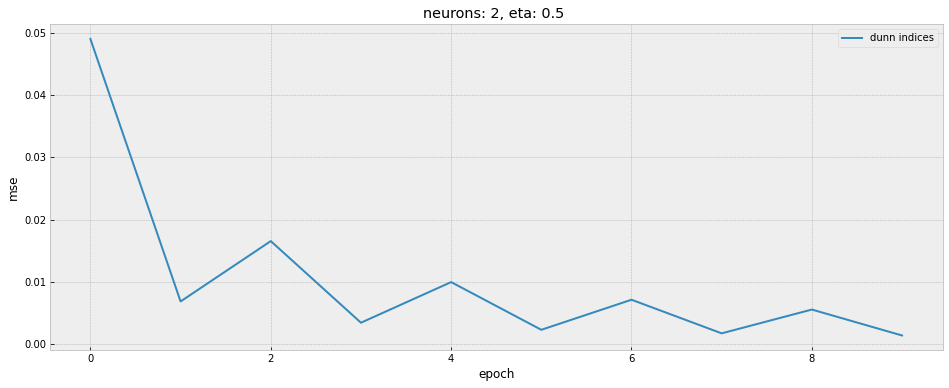

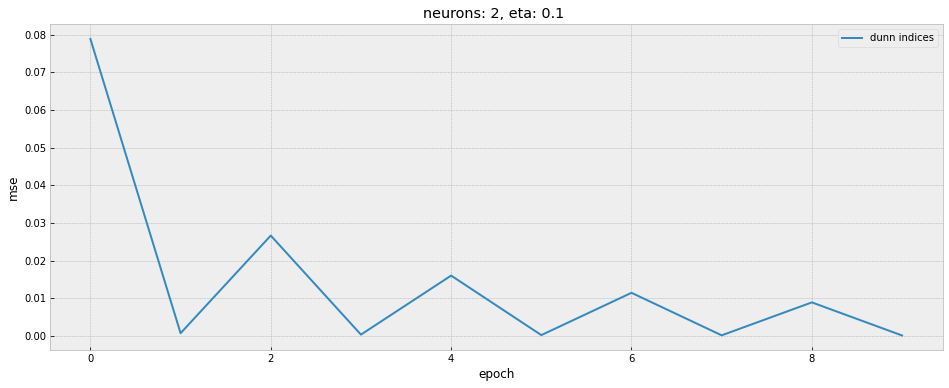

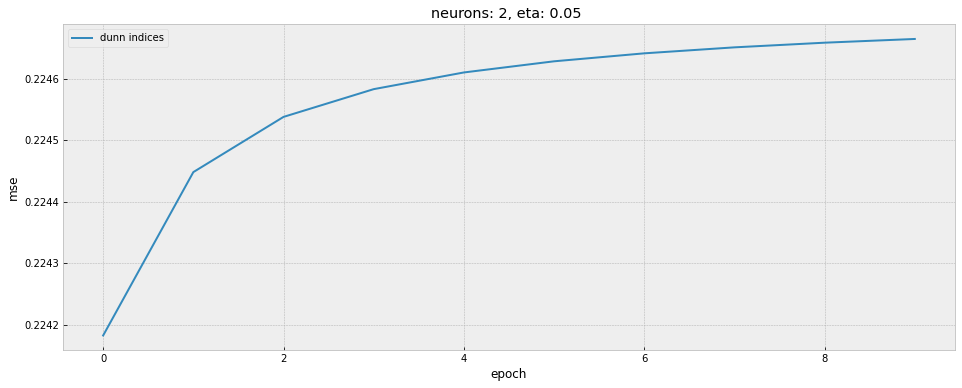

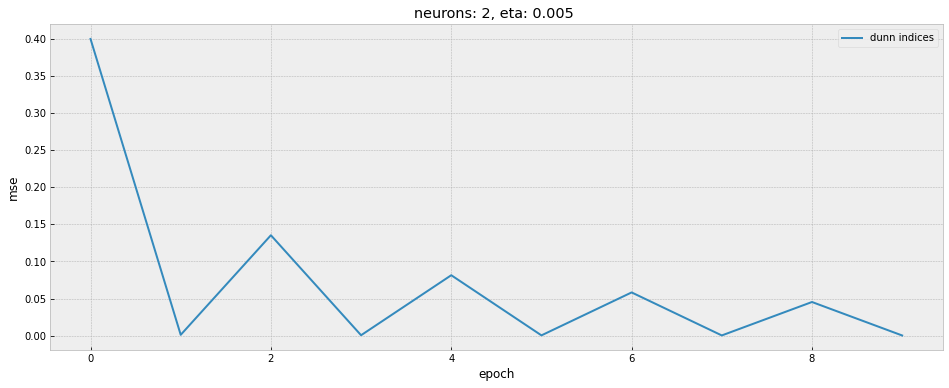

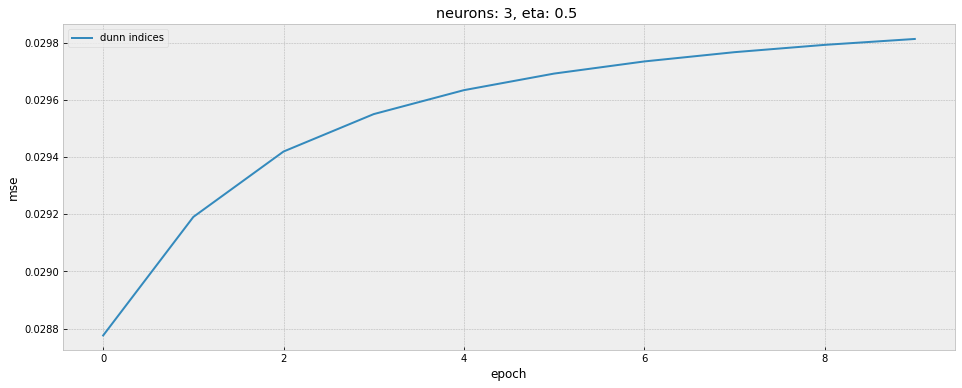

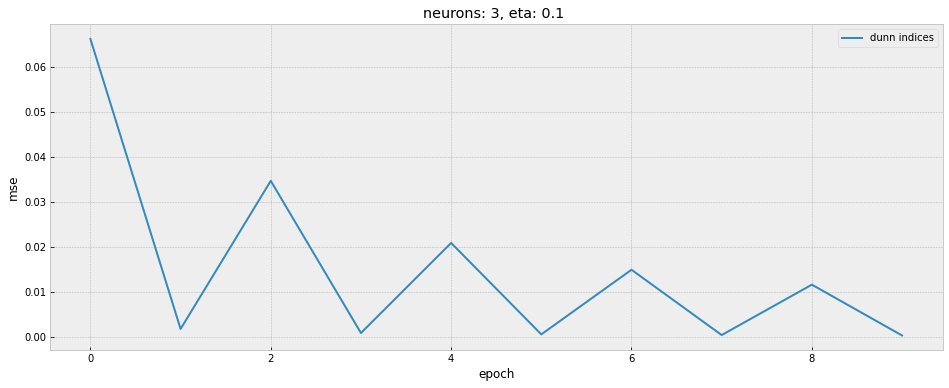

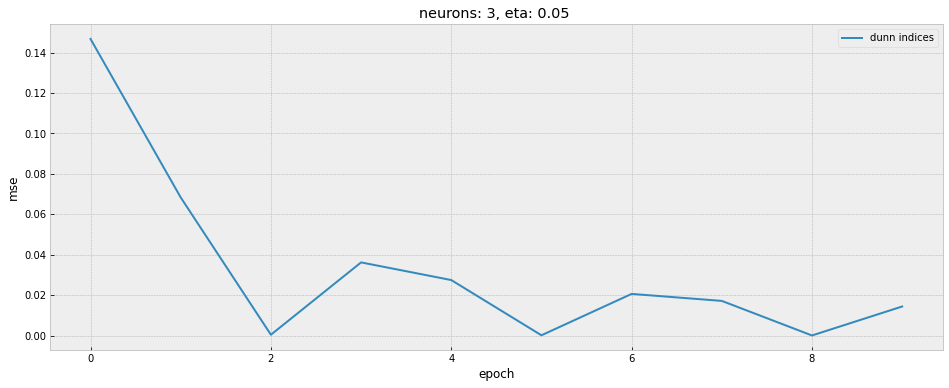

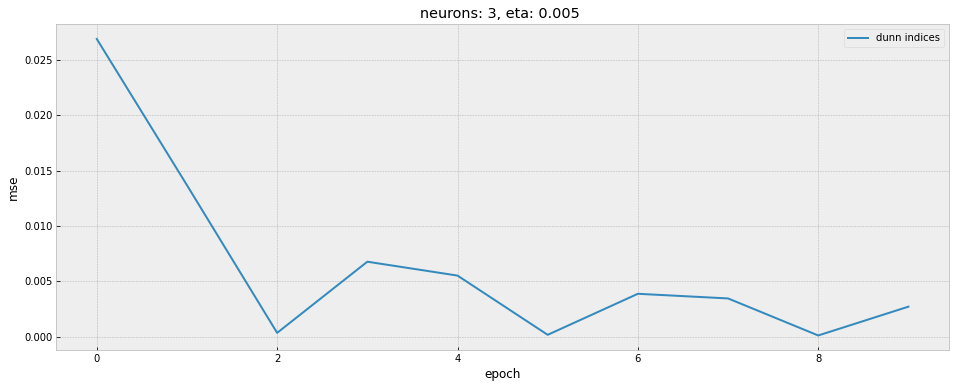

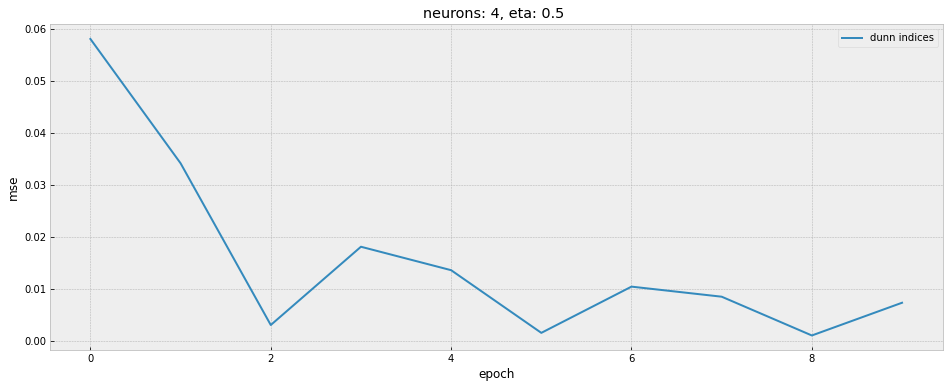

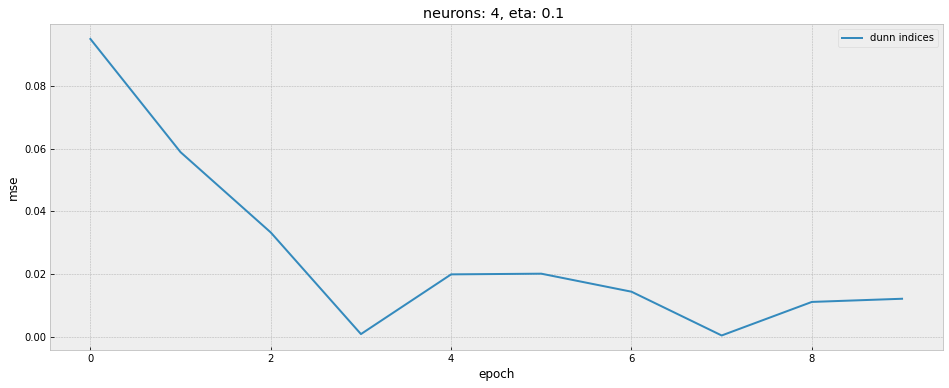

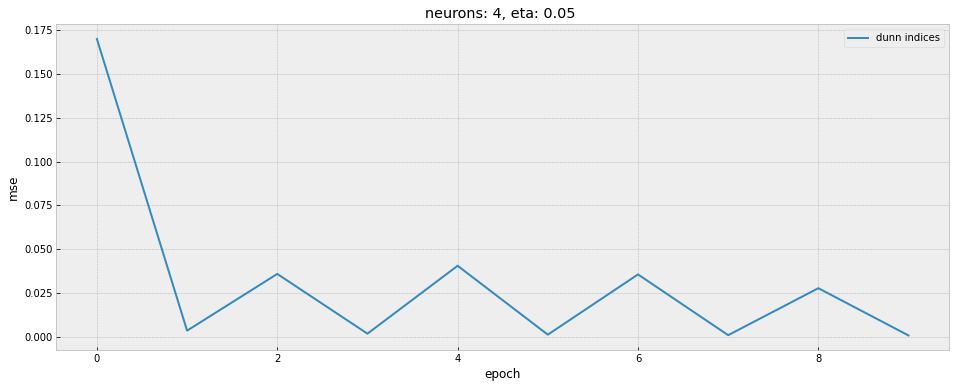

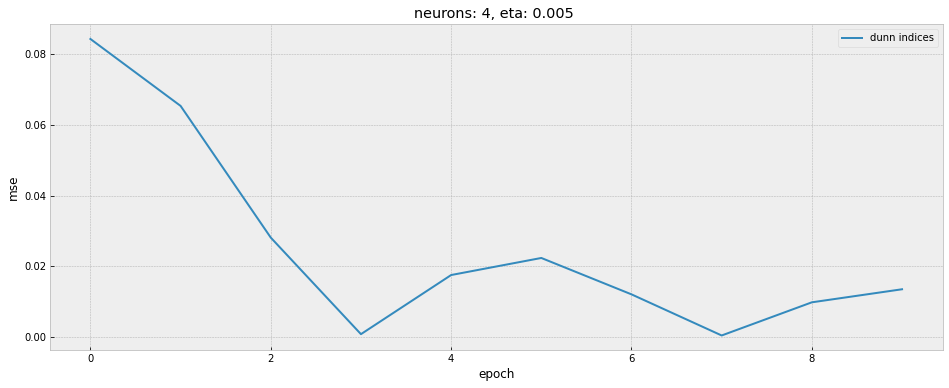

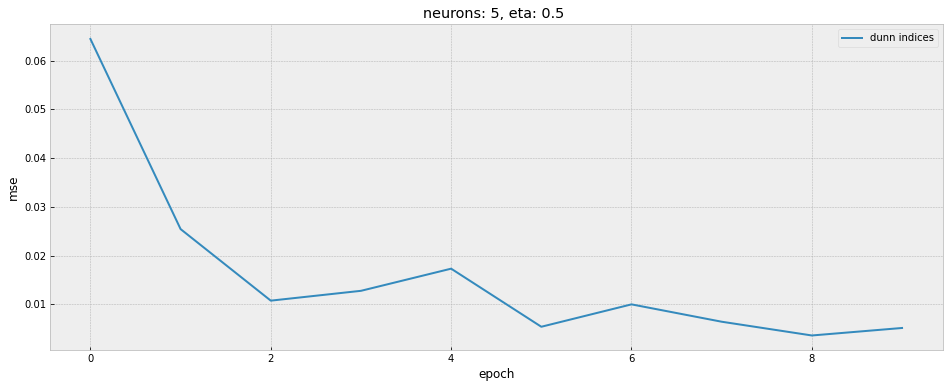

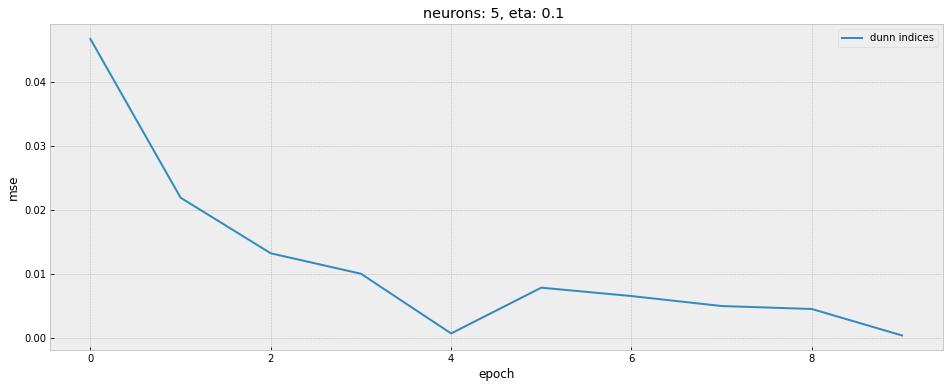

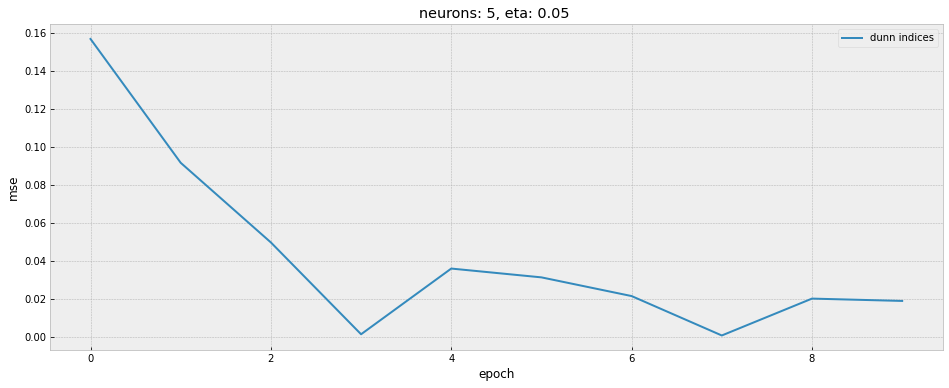

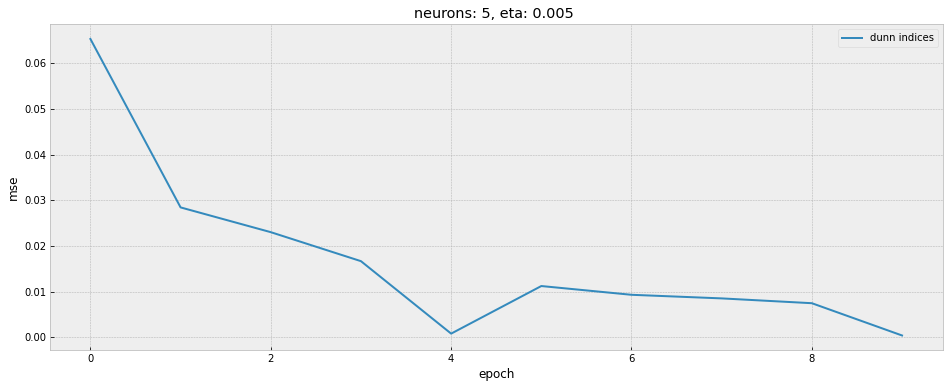

In [24]:
# plt.plot(df['mse list'], label='mse')
for i in range(15):
    plt.plot(df['indices'][i], label='dunn indices')
    plt.title('neurons: {}, eta: {} '.format(df['neurons'][i], df['learning rate'][i]))
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.legend()
    ax, fig = plt.subplots()
plt.plot(df['indices'][15], label='dunn indices')
plt.title('neurons: {}, eta: {} '.format(df['neurons'][15], df['learning rate'][15]))
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend()

## Závěr
Dunnův index vykázal rostoucí tendenci jen ve dvou případech.
Možné vysvětlení může být algoritmus učení, který má rostoucí sklon k jedinému vítěznému neuronu.